In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from matplotlib import pyplot as plt

In [2]:
import os
import function_training
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
import json

import numpy as np
import tensorflow as tf
import keras_tuner as kt
from tensorboard.plugins.hparams import api as hp

from dataLoader import AnyDataset
import function_training
from function_training import confusion_matrix
# from config import args
from config import hyperparameters, args, CNN_model

# numBands=100
bands_type="spin up"
debug = 0

Init Plugin
Init Graph Optimizer
Init Kernel


In [3]:
hyperparameters = {
        "learning_rate": 0.000005,
        "epochs": 600,
        "batch_size": 32,
}

In [4]:
# step 0. Check GPUs available:
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available:", len(gpus))
# set device
device = tf.device('/GPU:0') if len(gpus) != 0 else tf.device('/CPU:0')

Num GPUs Available: 1
Metal device set to: Apple M1 Pro


In [5]:
# step 1. prepare dataset
def json2inputlabel(data_json, bands_type="spin up", gamma=1):
    _bands_type = {"spin up": "spin_up_bands",
                   "spin down": "spin_down_bands",
                   "soc": "soc_bands"}
    
#     ## Original input bands
#     data_input_np = np.array(data_json[_bands_type[bands_type]])
    
    ## Trial: input 40*400 and take gamma point only
    data_input_np = np.array(data_json[_bands_type[bands_type]])
    
    if gamma:
        for pts in data_json["k_labels"]:
    #         print (pts[0], pts[1])
            if pts[0] == 'G':
                if debug:
                    print (pts[0], pts[1])

    #             if pts[1] != 0:
    #                 print (f'({pts[0]}, {pts[1]}) || layers num: {data_json["layers_num"]}')
                gamma_point = pts[1]
                break


        data_input_np = data_input_np[:,gamma_point]
        if debug:
            print (f'data_input_np: {data_input_np.shape}')
        
    ## labels
    data_label_np = np.array([data_json["new_label"]])

    return data_input_np, data_label_np


#take data and set batch size here
train_dataset = AnyDataset("list/actual/train_set.txt", json2inputlabel, args["load"]["numClasses"],bands_type, training=True)
test_dataset = AnyDataset("list/actual/test_set.txt", json2inputlabel, args["load"]["numClasses"],bands_type, training=False)
train_loader = tf.data.Dataset.from_tensor_slices((train_dataset.data_inputs, train_dataset.data_labels)).shuffle(train_dataset.len).batch(hyperparameters['batch_size'])
test_loader = tf.data.Dataset.from_tensor_slices((test_dataset.data_inputs,test_dataset.data_labels)).shuffle(test_dataset.len).batch(hyperparameters['batch_size'])


Loading test set: 100%|██████████████████████████████████████████████████████████████| 139/139 [00:00<00:00, 248.43it/s]


In [6]:
# # with open("../../c2db_database02_output_eigenvalue_norm/c2db_AuCl2S2Sr2-2c3ca0de8040.json", "r") as file:
# with open("../../c2db_database02_output_eigenvalue_norm_40x400/c2db_AuCl2S2Sr2-2c3ca0de8040.json", "r") as file:
#     data_json = json.load(file)

In [7]:
# for pts in data_json["k_labels"]:
#     print (pts[0], pts[1])
#     if pts[0] == 'G':
# #         print (pts[0], pts[1])
#         gamma_point = pts[1]
# #         break

In [8]:
# gamma_point

In [9]:
# # train_dataset.data_inputs[0][0]
# train_dataset_input = np.array(train_dataset.data_inputs)
# test_dataset_input = np.array(test_dataset.data_inputs)

In [10]:
# train_dataset_input[0][:,gamma_point].shape

## test ended ##

In [11]:
# np.array(test_dataset.data_labels).shape[0]

In [12]:
# train_dataset_labels = np.array(train_dataset.data_labels).reshape(np.array(train_dataset.data_labels).shape[0],)
# test_dataset_labels = np.array(test_dataset.data_labels).reshape(np.array(test_dataset.data_labels).shape[0],)

In [13]:
# idx = np.random.permutation(len(data))
# x,y = data[idx], classes[idx]

In [14]:
MLP_model = [
    tf.keras.layers.Flatten(input_shape=(40, )),
#     tf.keras.layers.Flatten(input_shape=(40, 400)),
    # tf.keras.layers.Flatten(input_shape=(60, 400)),
    tf.keras.layers.LeakyReLU(),
    
    
    tf.keras.layers.Dense(625, use_bias=True, bias_initializer='zeros',
                          kernel_regularizer=tf.keras.regularizers.L1(0.7),
                          activity_regularizer=tf.keras.regularizers.L2(0.3)),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(5000, use_bias=True, bias_initializer='zeros',
                          kernel_regularizer=tf.keras.regularizers.L1(0.7),
                          activity_regularizer=tf.keras.regularizers.L2(0.3)),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.3),


    tf.keras.layers.Dense(500, use_bias=True, bias_initializer='zeros',
                          kernel_regularizer=tf.keras.regularizers.L1(0.7),
                          activity_regularizer=tf.keras.regularizers.L2(0.3)),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(125, use_bias=True, bias_initializer='zeros',
                          kernel_regularizer=tf.keras.regularizers.L1(0.7),
                          activity_regularizer=tf.keras.regularizers.L2(0.3)),
    tf.keras.layers.LeakyReLU(),

    tf.keras.layers.Dense(args["load"]["numClasses"]), ####
#     tf.keras.layers.Dense(5),
    tf.keras.layers.LeakyReLU(),
#     tf.keras.layers.Softmax()
]

# MLP_model = [
#     tf.keras.layers.Flatten(input_shape=(40, 400)),
#     # tf.keras.layers.Flatten(input_shape=(60, 400)),
#     tf.keras.layers.LeakyReLU(),

# #     tf.keras.layers.Dense(10000, use_bias=True, bias_initializer='zeros',
# #                           kernel_regularizer=tf.keras.regularizers.L1(0.7),
# #                           activity_regularizer=tf.keras.regularizers.L2(0.3)),
# #     tf.keras.layers.LeakyReLU(),
# #     tf.keras.layers.Dropout(0.3),
    
    
# #     tf.keras.layers.Dense(625, use_bias=True, bias_initializer='zeros',
# #                           kernel_regularizer=tf.keras.regularizers.L1(0.7),
# #                           activity_regularizer=tf.keras.regularizers.L2(0.3)),
# #     tf.keras.layers.LeakyReLU(),
# #     tf.keras.layers.Dropout(0.3),

#     tf.keras.layers.Dense(5000, use_bias=True, bias_initializer='zeros',
#                           kernel_regularizer=tf.keras.regularizers.L1(0.7),
#                           activity_regularizer=tf.keras.regularizers.L2(0.3)),
#     tf.keras.layers.LeakyReLU(),
#     tf.keras.layers.Dropout(0.3),


#     tf.keras.layers.Dense(500, use_bias=True, bias_initializer='zeros',
#                           kernel_regularizer=tf.keras.regularizers.L1(0.7),
#                           activity_regularizer=tf.keras.regularizers.L2(0.3)),
#     tf.keras.layers.LeakyReLU(),
#     tf.keras.layers.Dropout(0.3),

#     tf.keras.layers.Dense(125, use_bias=True, bias_initializer='zeros',
#                           kernel_regularizer=tf.keras.regularizers.L1(0.7),
#                           activity_regularizer=tf.keras.regularizers.L2(0.3)),
#     tf.keras.layers.LeakyReLU(),


#     tf.keras.layers.Dense(5),
#     tf.keras.layers.LeakyReLU(),
# #     tf.keras.layers.Softmax()
# ]


# MLP_model = [
#     tf.keras.layers.Flatten(input_shape=(60, 100)),
#     # tf.keras.layers.Flatten(input_shape=(60, 400)),
#     tf.keras.layers.LeakyReLU(),

# #     tf.keras.layers.Dense(10000, use_bias=True, bias_initializer='zeros',
# #                           kernel_regularizer=tf.keras.regularizers.L1(0.7),
# #                           activity_regularizer=tf.keras.regularizers.L2(0.3)),
# #     tf.keras.layers.LeakyReLU(),
# #     tf.keras.layers.Dropout(0.3),
    
    
#     tf.keras.layers.Dense(625, use_bias=True, bias_initializer='zeros',
#                           kernel_regularizer=tf.keras.regularizers.L1(0.7),
#                           activity_regularizer=tf.keras.regularizers.L2(0.3)),
#     tf.keras.layers.LeakyReLU(),
#     tf.keras.layers.Dropout(0.3),

#     tf.keras.layers.Dense(5000, use_bias=True, bias_initializer='zeros',
#                           kernel_regularizer=tf.keras.regularizers.L1(0.7),
#                           activity_regularizer=tf.keras.regularizers.L2(0.3)),
#     tf.keras.layers.LeakyReLU(),
#     tf.keras.layers.Dropout(0.3),


#     tf.keras.layers.Dense(500, use_bias=True, bias_initializer='zeros',
#                           kernel_regularizer=tf.keras.regularizers.L1(0.7),
#                           activity_regularizer=tf.keras.regularizers.L2(0.3)),
#     tf.keras.layers.LeakyReLU(),
#     tf.keras.layers.Dropout(0.3),

#     tf.keras.layers.Dense(125, use_bias=True, bias_initializer='zeros',
#                           kernel_regularizer=tf.keras.regularizers.L1(0.7),
#                           activity_regularizer=tf.keras.regularizers.L2(0.3)),
#     tf.keras.layers.LeakyReLU(),


#     tf.keras.layers.Dense(5),
#     tf.keras.layers.LeakyReLU(),
# #     tf.keras.layers.Softmax()
# ]


In [15]:
# step 2. build model
model = tf.keras.Sequential(MLP_model)

# step 3. define loss
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

# # step 4. Model compile
lr_scheduler = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=hyperparameters['learning_rate'],
    decay_steps=10000,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_scheduler)

# step 5. select metrics
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [16]:
# step 6. train & evaluate & save model
losses_train, accuracy_train, losses_test, accuracy_test, model = function_training.train_it(device, model, "./state_dicts/",
                                                                                      hyperparameters['epochs'],train_loader, test_loader, loss_fn, optimizer,
                                                                                      train_loss, train_accuracy, test_loss, test_accuracy,
                                                                                      eval_num_epochs=1, numClasss=args["load"]["numClasses"])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 40)                0         
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 40)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 625)               25625     
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 625)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 625)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 5000)              3130000   
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 5000)              0

2022-07-16 06:17:52.710699: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1 | Loss:   3.4468610286712646 | Accuracy (%):   18.709150314331055
	Test Loss:  2.0479180812835693  |  Test Accuracy (%): 28.776979446411133
Epoch 2 | Loss:   2.3384549617767334 | Accuracy (%):   21.568628311157227
	Test Loss:  2.04338002204895  |  Test Accuracy (%): 34.53237533569336
Epoch 3 | Loss:   2.106560707092285 | Accuracy (%):   26.87908363342285
	Test Loss:  2.0212814807891846  |  Test Accuracy (%): 35.251800537109375
Epoch 4 | Loss:   2.0210626125335693 | Accuracy (%):   28.104576110839844
	Test Loss:  1.926055908203125  |  Test Accuracy (%): 35.251800537109375
Epoch 5 | Loss:   1.960254430770874 | Accuracy (%):   29.411766052246094
	Test Loss:  1.8722561597824097  |  Test Accuracy (%): 34.53237533569336
Epoch 6 | Loss:   1.9682310819625854 | Accuracy (%):   31.45425033569336
	Test Loss:  1.9143532514572144  |  Test Accuracy (%): 35.251800537109375
Epoch 7 | Loss:   1.8857003450393677 | Accuracy (%):   34.06863021850586
	Test Loss:  1.8670791387557983  |  Test Accurac

Epoch 57 | Loss:   1.660887360572815 | Accuracy (%):   40.767974853515625
	Test Loss:  1.7194498777389526  |  Test Accuracy (%): 40.28777313232422
Epoch 58 | Loss:   1.641728162765503 | Accuracy (%):   40.68627166748047
	Test Loss:  1.707274317741394  |  Test Accuracy (%): 42.446044921875
Epoch 59 | Loss:   1.645813226699829 | Accuracy (%):   40.19607925415039
	Test Loss:  1.7760871648788452  |  Test Accuracy (%): 40.28777313232422
Epoch 60 | Loss:   1.6614373922348022 | Accuracy (%):   39.379085540771484
	Test Loss:  1.6995127201080322  |  Test Accuracy (%): 44.60431671142578
Epoch 61 | Loss:   1.6447335481643677 | Accuracy (%):   41.09477233886719
	Test Loss:  1.7252848148345947  |  Test Accuracy (%): 38.84892272949219
Epoch 62 | Loss:   1.6391446590423584 | Accuracy (%):   40.767974853515625
	Test Loss:  1.6843290328979492  |  Test Accuracy (%): 41.726619720458984
Epoch 63 | Loss:   1.6519070863723755 | Accuracy (%):   40.767974853515625
	Test Loss:  1.6680940389633179  |  Test Accu

Epoch 113 | Loss:   1.5987389087677002 | Accuracy (%):   41.42156982421875
	Test Loss:  1.7161610126495361  |  Test Accuracy (%): 44.60431671142578
Epoch 114 | Loss:   1.6039050817489624 | Accuracy (%):   42.56536102294922
	Test Loss:  1.7552677392959595  |  Test Accuracy (%): 41.726619720458984
Epoch 115 | Loss:   1.6003673076629639 | Accuracy (%):   41.42156982421875
	Test Loss:  1.684104323387146  |  Test Accuracy (%): 44.60431671142578
Epoch 116 | Loss:   1.602486491203308 | Accuracy (%):   41.17647171020508
	Test Loss:  1.6919090747833252  |  Test Accuracy (%): 44.60431671142578
Epoch 117 | Loss:   1.6113760471343994 | Accuracy (%):   41.50326919555664
	Test Loss:  1.6555184125900269  |  Test Accuracy (%): 44.60431671142578
Epoch 118 | Loss:   1.6037840843200684 | Accuracy (%):   42.40196228027344
	Test Loss:  1.7386085987091064  |  Test Accuracy (%): 44.60431671142578
Epoch 119 | Loss:   1.5988852977752686 | Accuracy (%):   41.8300666809082
	Test Loss:  1.6690739393234253  |  Tes

Epoch 169 | Loss:   1.6023181676864624 | Accuracy (%):   41.911766052246094
	Test Loss:  1.6917814016342163  |  Test Accuracy (%): 45.3237419128418
Epoch 170 | Loss:   1.5652732849121094 | Accuracy (%):   42.48366165161133
	Test Loss:  1.6725739240646362  |  Test Accuracy (%): 45.3237419128418
Epoch 171 | Loss:   1.5805959701538086 | Accuracy (%):   42.156864166259766
	Test Loss:  1.6515852212905884  |  Test Accuracy (%): 45.3237419128418
Epoch 172 | Loss:   1.5738060474395752 | Accuracy (%):   42.156864166259766
	Test Loss:  1.685027003288269  |  Test Accuracy (%): 45.3237419128418
Epoch 173 | Loss:   1.5905190706253052 | Accuracy (%):   42.728759765625
	Test Loss:  1.6913765668869019  |  Test Accuracy (%): 44.60431671142578
Epoch 174 | Loss:   1.585679054260254 | Accuracy (%):   41.58496856689453
	Test Loss:  1.646706223487854  |  Test Accuracy (%): 45.3237419128418
Epoch 175 | Loss:   1.5874067544937134 | Accuracy (%):   42.32026290893555
	Test Loss:  1.679296851158142  |  Test Accu

Epoch 225 | Loss:   1.567744255065918 | Accuracy (%):   42.238563537597656
	Test Loss:  1.663996696472168  |  Test Accuracy (%): 42.446044921875
Epoch 226 | Loss:   1.567252278327942 | Accuracy (%):   42.075164794921875
	Test Loss:  1.6153579950332642  |  Test Accuracy (%): 44.60431671142578
Epoch 227 | Loss:   1.563293218612671 | Accuracy (%):   42.32026290893555
	Test Loss:  1.6612507104873657  |  Test Accuracy (%): 41.726619720458984
Epoch 228 | Loss:   1.5779362916946411 | Accuracy (%):   41.8300666809082
	Test Loss:  1.6282787322998047  |  Test Accuracy (%): 41.726619720458984
Epoch 229 | Loss:   1.560864806175232 | Accuracy (%):   41.911766052246094
	Test Loss:  1.7209045886993408  |  Test Accuracy (%): 42.446044921875
Epoch 230 | Loss:   1.5736284255981445 | Accuracy (%):   42.32026290893555
	Test Loss:  1.6299927234649658  |  Test Accuracy (%): 41.00719451904297
Epoch 231 | Loss:   1.5911463499069214 | Accuracy (%):   41.58496856689453
	Test Loss:  1.691775918006897  |  Test Ac

Epoch 281 | Loss:   1.5730693340301514 | Accuracy (%):   42.156864166259766
	Test Loss:  1.6373142004013062  |  Test Accuracy (%): 45.3237419128418
Epoch 282 | Loss:   1.556666612625122 | Accuracy (%):   42.238563537597656
	Test Loss:  1.6473973989486694  |  Test Accuracy (%): 42.446044921875
Epoch 283 | Loss:   1.5602223873138428 | Accuracy (%):   42.156864166259766
	Test Loss:  1.6094229221343994  |  Test Accuracy (%): 41.726619720458984
Epoch 284 | Loss:   1.558518409729004 | Accuracy (%):   42.238563537597656
	Test Loss:  1.6532042026519775  |  Test Accuracy (%): 46.04316711425781
Epoch 285 | Loss:   1.5563887357711792 | Accuracy (%):   41.993465423583984
	Test Loss:  1.576918363571167  |  Test Accuracy (%): 45.3237419128418
Epoch 286 | Loss:   1.5557115077972412 | Accuracy (%):   41.666664123535156
	Test Loss:  1.6305102109909058  |  Test Accuracy (%): 41.00719451904297
Epoch 287 | Loss:   1.559128999710083 | Accuracy (%):   42.64706039428711
	Test Loss:  1.6991589069366455  |  Te

Epoch 337 | Loss:   1.5601803064346313 | Accuracy (%):   41.993465423583984
	Test Loss:  1.6413801908493042  |  Test Accuracy (%): 46.04316711425781
Epoch 338 | Loss:   1.5461243391036987 | Accuracy (%):   42.728759765625
	Test Loss:  1.7174049615859985  |  Test Accuracy (%): 43.165470123291016
Epoch 339 | Loss:   1.5407872200012207 | Accuracy (%):   41.74836730957031
	Test Loss:  1.5929228067398071  |  Test Accuracy (%): 42.446044921875
Epoch 340 | Loss:   1.5518399477005005 | Accuracy (%):   41.74836730957031
	Test Loss:  1.7067720890045166  |  Test Accuracy (%): 43.165470123291016
Epoch 341 | Loss:   1.5519473552703857 | Accuracy (%):   42.89215850830078
	Test Loss:  1.6442068815231323  |  Test Accuracy (%): 43.165470123291016
Epoch 342 | Loss:   1.5521105527877808 | Accuracy (%):   41.74836730957031
	Test Loss:  1.6028131246566772  |  Test Accuracy (%): 45.3237419128418
Epoch 343 | Loss:   1.5500702857971191 | Accuracy (%):   42.40196228027344
	Test Loss:  1.6297279596328735  |  Te

Epoch 393 | Loss:   1.5491456985473633 | Accuracy (%):   42.40196228027344
	Test Loss:  1.5921173095703125  |  Test Accuracy (%): 45.3237419128418
Epoch 394 | Loss:   1.5403660535812378 | Accuracy (%):   42.075164794921875
	Test Loss:  1.6406913995742798  |  Test Accuracy (%): 46.04316711425781
Epoch 395 | Loss:   1.5454168319702148 | Accuracy (%):   43.0555534362793
	Test Loss:  1.6007126569747925  |  Test Accuracy (%): 46.04316711425781
Epoch 396 | Loss:   1.531622290611267 | Accuracy (%):   41.666664123535156
	Test Loss:  1.6922779083251953  |  Test Accuracy (%): 45.3237419128418
Epoch 397 | Loss:   1.5466341972351074 | Accuracy (%):   42.32026290893555
	Test Loss:  1.6134346723556519  |  Test Accuracy (%): 46.04316711425781
Epoch 398 | Loss:   1.563078761100769 | Accuracy (%):   43.300655364990234
	Test Loss:  1.696245789527893  |  Test Accuracy (%): 45.3237419128418
Epoch 399 | Loss:   1.55632746219635 | Accuracy (%):   43.6274528503418
	Test Loss:  1.6268891096115112  |  Test Acc

Epoch 449 | Loss:   1.5423367023468018 | Accuracy (%):   43.13725662231445
	Test Loss:  1.6011618375778198  |  Test Accuracy (%): 45.3237419128418
Epoch 450 | Loss:   1.5386531352996826 | Accuracy (%):   43.13725662231445
	Test Loss:  1.603525996208191  |  Test Accuracy (%): 43.165470123291016
Epoch 451 | Loss:   1.5394021272659302 | Accuracy (%):   42.728759765625
	Test Loss:  1.6292717456817627  |  Test Accuracy (%): 44.60431671142578
Epoch 452 | Loss:   1.5212007761001587 | Accuracy (%):   43.0555534362793
	Test Loss:  1.6012951135635376  |  Test Accuracy (%): 44.60431671142578
Epoch 453 | Loss:   1.5355823040008545 | Accuracy (%):   43.13725662231445
	Test Loss:  1.6510871648788452  |  Test Accuracy (%): 45.3237419128418
Epoch 454 | Loss:   1.5431345701217651 | Accuracy (%):   41.666664123535156
	Test Loss:  1.6631834506988525  |  Test Accuracy (%): 45.3237419128418
Epoch 455 | Loss:   1.5301109552383423 | Accuracy (%):   42.32026290893555
	Test Loss:  1.6416218280792236  |  Test A

Epoch 505 | Loss:   1.5319427251815796 | Accuracy (%):   43.545753479003906
	Test Loss:  1.675018548965454  |  Test Accuracy (%): 42.446044921875
Epoch 506 | Loss:   1.5473408699035645 | Accuracy (%):   42.81045913696289
	Test Loss:  1.6840105056762695  |  Test Accuracy (%): 42.446044921875
Epoch 507 | Loss:   1.5400807857513428 | Accuracy (%):   43.464054107666016
	Test Loss:  1.5834017992019653  |  Test Accuracy (%): 43.165470123291016
Epoch 508 | Loss:   1.5424566268920898 | Accuracy (%):   42.728759765625
	Test Loss:  1.6611995697021484  |  Test Accuracy (%): 42.446044921875
Epoch 509 | Loss:   1.5320073366165161 | Accuracy (%):   43.218955993652344
	Test Loss:  1.6483200788497925  |  Test Accuracy (%): 45.3237419128418
Epoch 510 | Loss:   1.5423146486282349 | Accuracy (%):   43.70914840698242
	Test Loss:  1.6857566833496094  |  Test Accuracy (%): 42.446044921875
Epoch 511 | Loss:   1.5405653715133667 | Accuracy (%):   44.11764907836914
	Test Loss:  1.6990149021148682  |  Test Accu

Epoch 561 | Loss:   1.5362719297409058 | Accuracy (%):   42.48366165161133
	Test Loss:  1.6186792850494385  |  Test Accuracy (%): 44.60431671142578
Epoch 562 | Loss:   1.5258057117462158 | Accuracy (%):   42.89215850830078
	Test Loss:  1.6684216260910034  |  Test Accuracy (%): 44.60431671142578
Epoch 563 | Loss:   1.5226869583129883 | Accuracy (%):   42.64706039428711
	Test Loss:  1.6149711608886719  |  Test Accuracy (%): 44.60431671142578
Epoch 564 | Loss:   1.5283291339874268 | Accuracy (%):   42.64706039428711
	Test Loss:  1.6579077243804932  |  Test Accuracy (%): 43.165470123291016
Epoch 565 | Loss:   1.5370839834213257 | Accuracy (%):   43.38235092163086
	Test Loss:  1.615507960319519  |  Test Accuracy (%): 45.3237419128418
Epoch 566 | Loss:   1.5392135381698608 | Accuracy (%):   42.64706039428711
	Test Loss:  1.6323102712631226  |  Test Accuracy (%): 42.446044921875
Epoch 567 | Loss:   1.5254948139190674 | Accuracy (%):   43.38235092163086
	Test Loss:  1.6215766668319702  |  Test

2022-07-16 06:21:32.446921: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./state_dicts/assets


In [17]:
test_loader2 = tf.data.Dataset.from_tensor_slices((test_dataset.data_inputs,test_dataset.data_labels)).shuffle(train_dataset.len).batch(1000)

# model2 = tf.keras.Sequential(MLP_model)

for element, labels in test_loader2:
#     print (element)
#     print (labels)
#     np.maximum([model(element, training=False)])
    predict = np.argmax(model.predict(element), axis=-1)
    label = np.array(labels).flatten()
#     print (f"model {model.predict_classes(element)}, actual {labels}")
#     model.predict_classes(element)
    break


In [18]:
# m = tf.keras.metrics.Accuracy()
# m.update_state(label, predict)
# m.result().numpy()


from sklearn.metrics import accuracy_score
mse = accuracy_score(y_true=label, y_pred=predict)
mse

0.43884892086330934

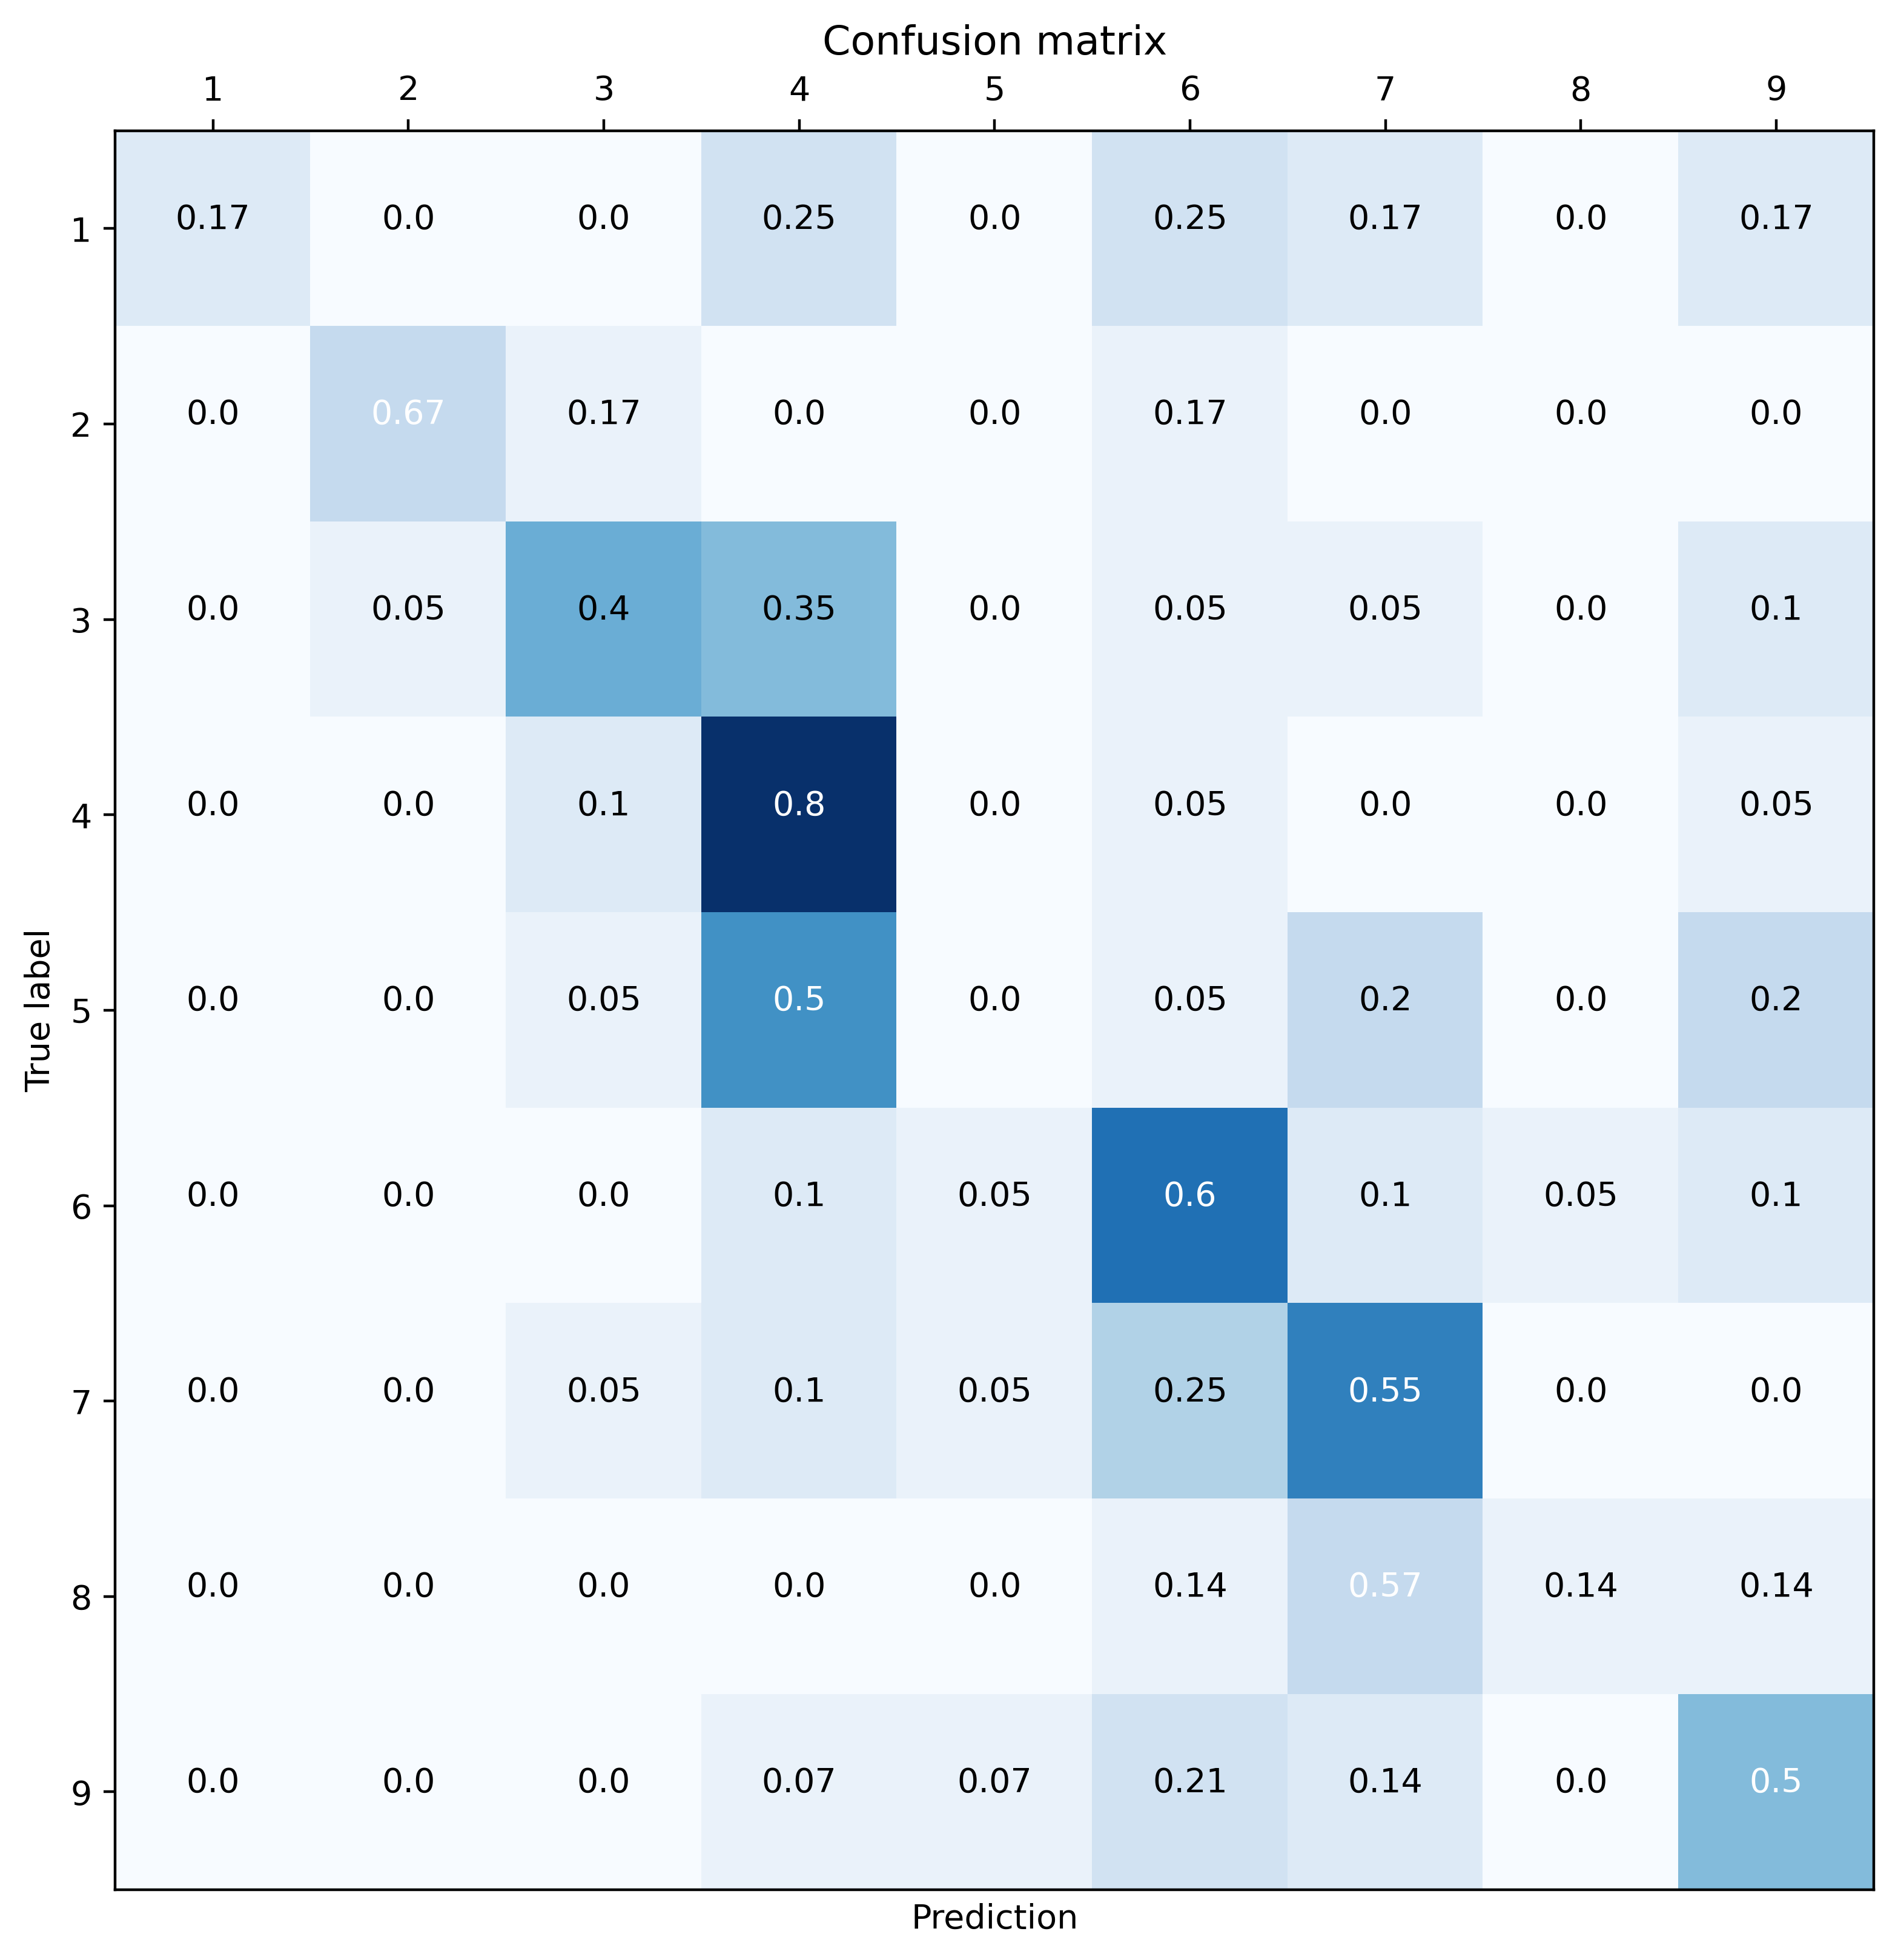

In [19]:
# confusion_matrix(labels=label, predictions=predict, class_names=[3, 4, 5, 6, 7])
confusion_matrix(labels=label, predictions=predict, class_names=np.arange(1,10,1).tolist())